1. Скачайте текст произведения «Война и мир»: ссылка на GitHub.

2. Очистите его, оставив только русские буквы и символы пробела.

3. Постройте матрицу переходных вероятностей.

4. Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».

5. Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.

6. Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.

7. Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.

In [32]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

import io, pickle, zipfile
from zipfile import ZipFile

from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('war_and_peace.ru.txt', 'r', encoding="utf-8") as f:
    text = f.read().lower()
text = re.sub('[^а-я ]','', text)

In [3]:
text;

In [4]:
print(set(text))

{'з', 'д', 'н', 'т', 'ж', 'и', 'е', 'п', 'ы', 'в', 'х', 'я', 'ц', 'й', 'у', 'л', ' ', 'э', 'ф', 'к', 'а', 'ш', 'ъ', 'о', 'ь', 'с', 'щ', 'р', 'г', 'ч', 'м', 'б', 'ю'}


In [5]:
rus = ''.join(sorted(set(text)))
rus

' абвгдежзийклмнопрстуфхцчшщъыьэюя'

In [6]:
# a = ord('а') # способ получить буквы русского алфавита (без "ё")
# rus = ''.join([chr(i) for i in range(a, a + 32)]) + ' ' # добавить пробел

# rus

In [7]:
POS = {l: i for i, l in enumerate(rus)}

In [8]:
probabilities = np.zeros((len(rus), len(rus)))

In [9]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [10]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [11]:
df = pd.DataFrame(probabilities, index=(c for c in rus), columns=(c for c in rus))

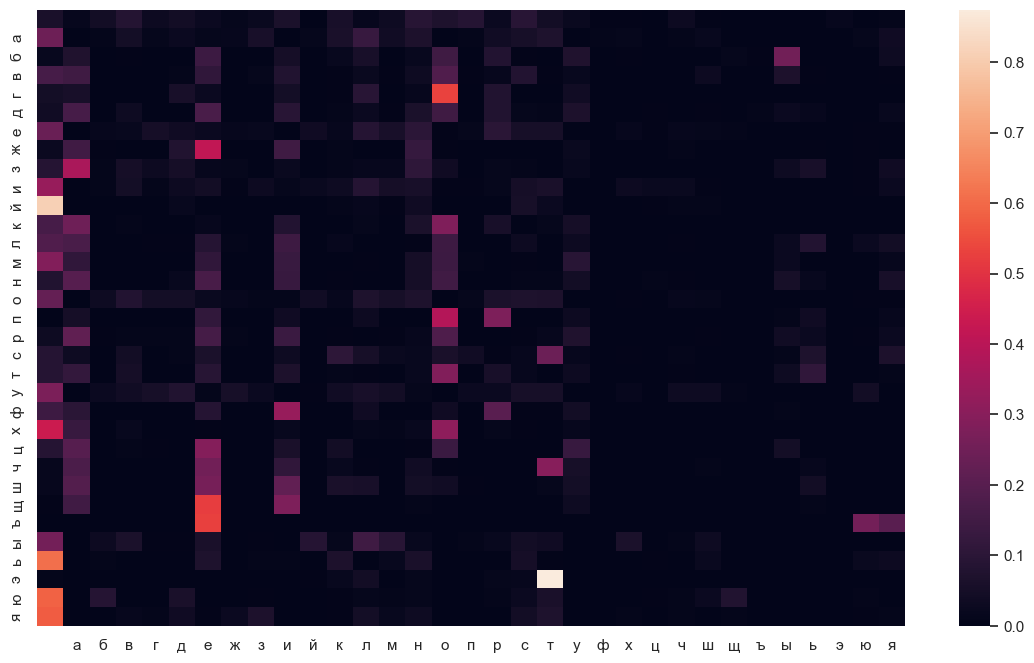

In [12]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р»

In [73]:
start = POS['п']
end = POS['р']

result = 0
count = 0

prior = 1. / len(rus)
for c in rus[1:]:
    for c in rus[1:]:
        proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], POS[b]] *probabilities[POS[b], end] 
    
        if proba > 0:
            result += proba
            count += 1
print(f'Вероятность строки из 4 букв {result}, всего вариантов строк {count}')            

Вероятность строки из 4 букв 2.8899261152176357e-05, всего вариантов строк 448


Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов

In [80]:
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length - 1):
    index = POS[s[i]]
    next_char = np.random.choice(list(rus), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

багоминс


Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM

In [23]:
with ZipFile('Series.zip', 'r') as myzip:
    for item in myzip.infolist():
        print(f'File Name: {item.filename} ')

File Name: international-airline-passengers.csv 
File Name: mean-monthly-air-temperature-deg.csv 
File Name: monthly-boston-armed-robberies-j.csv 
File Name: monthly-sales-of-company-x-jan-6.csv 
File Name: weekly-closings-of-the-dowjones-.csv 
File Name: daily-total-female-births-in-cal.csv 


In [24]:
with ZipFile('Series.zip', 'r') as myzip:
    myzip.extractall()
    
df = pd.read_csv('international-airline-passengers.csv')   # для модели ARIMA 
int_air_pass = pd.read_csv('international-airline-passengers.csv').iloc[:, 1]  
F = pd.read_csv('international-airline-passengers.csv').iloc[:, 1]

In [26]:
values = F.values.reshape(-1,1)

In [61]:
for n in range(1, 14):
    model = GaussianHMM(n_components = n,
                        covariance_type = "diag",
                        n_iter = 1000)
    model.fit(values)
    print(n, model.score(values))

1 -893.1837902090575
2 -803.8479628607707
3 -781.1969820008698
4 -767.0796863584054
5 -771.4084922845748
6 -739.2239399178903
7 -765.6507014863558
8 -715.5194603183098
9 -689.9804920950025
10 -699.1176945918062


Fitting a model with 167 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 144 data points will result in a degenerate solution.


11 -685.1111969915878
12 -710.6959297987619
13 -695.0821845419833


Fitting a model with 167 free scalar parameters with only 144 data points will result in a degenerate solution.


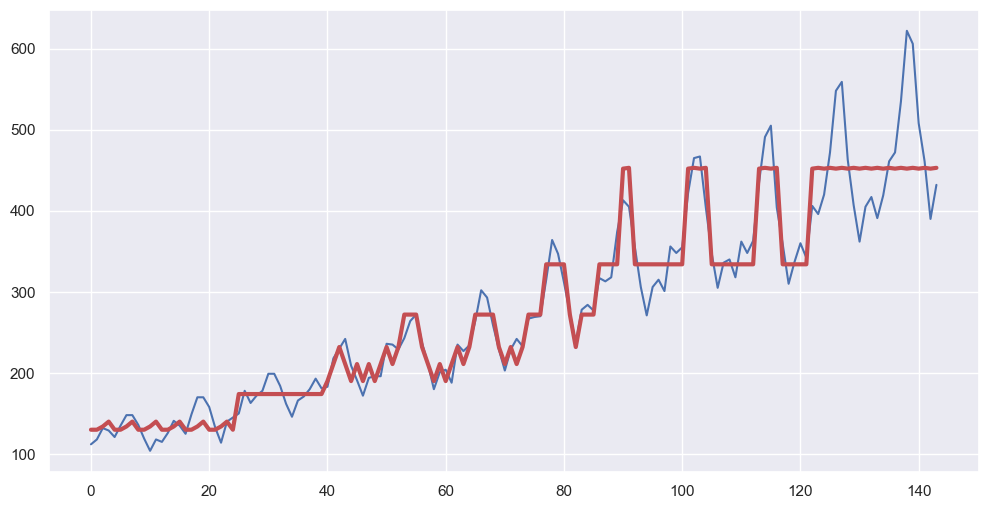

In [66]:
# Возьмем модель с 12 состояниями

model = GaussianHMM(n_components = 12,
                        covariance_type = "diag",
                        n_iter = 1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3, c='r')

In [67]:
model.transmat_.shape

(12, 12)

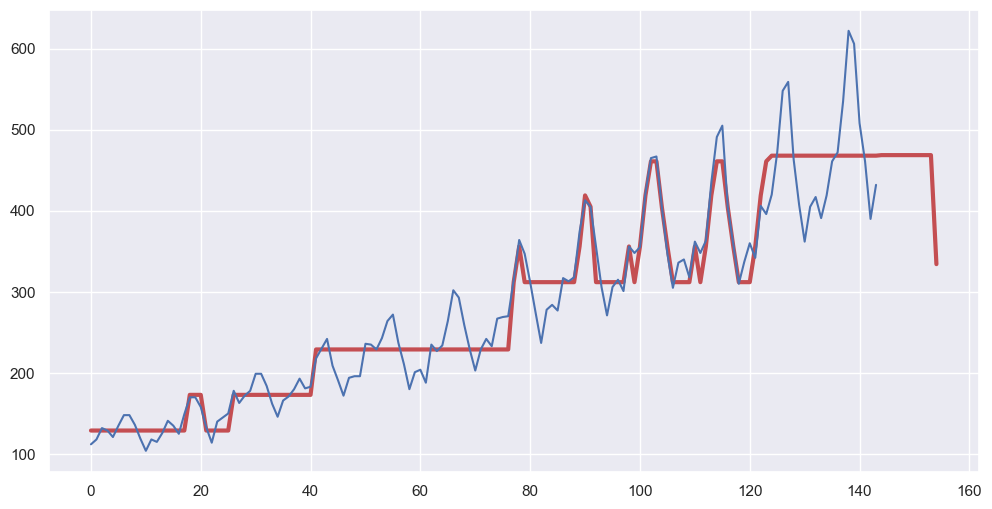

In [69]:
# Построим предсказания на n шагов
n = 10 
forecast = means
last_label = labels[-1]
for i in range(n):
  last_label = np.random.choice(list(range(model.n_components)), p=model.transmat_[last_label])
  forecast = np.concatenate((prognos, model.means_[last_label].reshape(-1,1)))

plt.figure(figsize=(12, 6))
plt.plot(forecast, linewidth=3, c='r')
plt.plot(values)  